### Data  
full - 차가 다 차있는 데이터  
free - 조금 비어있는 데이터

In [1]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

Using TensorFlow backend.
C:\Users\ui88g\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ui88g\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ui88g\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ui88g\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

#### OOM 막기 위해 GPU할당 제한

In [2]:
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.4 
session = tf.Session(config=config)


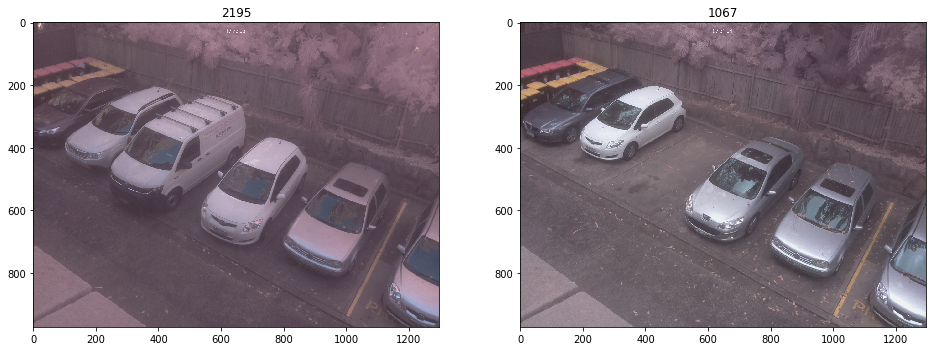

In [2]:
BASE_PATH = './car_data/data/data'

full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.jpg'))

# 예시로 이미지 하나씩 확인
full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)


plt.figure(figsize=(16,16))
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

## DataGenerator

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    shear_range=0.01,
    zoom_range=[0.9,1.1],
    ## 중요 10퍼센트가 validation set
    validation_split=0.1,
    ## 중요 mobileNetV2에 넣기위해 전처리하는 함수
    preprocessing_function=preprocess_input
)

# validation - augmentation필요 없음
val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224,224),
    classes=['Full', 'Free'],
    # full 이면 [0,1] , free면 [1, 0]로 아웃풋 (categorial)
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    subset='training'
)


val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224,224),
    classes=['Full', 'Free'],
    # full 이면 [1,0] , free면 [0, 1]로 아웃풋 (categorial)
    class_mode='categorical',
    batch_size=4,
    shuffle=False,
    subset='validation'
)

# Class index 확인
print(val_gen.class_indices)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


## Load Model for transfer learning  
imagenet pretrained model 


In [4]:
# include_top = False : 모델 윗부분-output은 우리가 정해줄것이기때문에 False
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

x = base_model.output
# data를 1차원으로 펴줌
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, output=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

C:\Users\ui88g\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

### False일 경우 학습을 진행해도 layer의 weight가 변하지 않으므로 True로 설정

In [5]:
for layer in model.layers:
    layer.trainable = True

## Train

In [7]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)]
    )


Epoch 1/10
735/735 [==============================] - 308s 419ms/step - loss: 0.2554 - acc: 0.9142 - val_loss: 0.0000e+00 - val_acc: 0.3262

Epoch 00001: val_acc improved from -inf to 0.32615, saving model to model.h5
Epoch 2/10
735/735 [==============================] - 285s 388ms/step - loss: 0.0865 - acc: 0.9734 - val_loss: 10.5536 - val_acc: 0.6738

Epoch 00002: val_acc improved from 0.32615 to 0.67385, saving model to model.h5
Epoch 3/10
735/735 [==============================] - 286s 389ms/step - loss: 0.0739 - acc: 0.9745 - val_loss: 10.1594 - val_acc: 0.6738

Epoch 00003: val_acc did not improve from 0.67385
Epoch 4/10
735/735 [==============================] - 286s 389ms/step - loss: 0.0574 - acc: 0.9860 - val_loss: 2.5496e-04 - val_acc: 0.8985

Epoch 00004: val_acc improved from 0.67385 to 0.89846, saving model to model.h5
Epoch 5/10
735/735 [==============================] - 286s 389ms/step - loss: 0.0438 - acc: 0.9877 - val_loss: 5.9956e-04 - val_acc: 0.3385

Epoch 00005: 

## Create New Model

In [7]:
model = load_model('model.h5')

# 모델의 마지막 레이어의 웨이트
last_weight = model.layers[-1].get_weights()[0] # (1280,2)

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features,
        model.layers[-1].output
    )
)

new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

## Normal prediction

test_img.shape (224, 224, 3)
test_input.shape (1, 224, 224, 3)
pred[0]: [3.6813855e-08 1.0000000e+00]


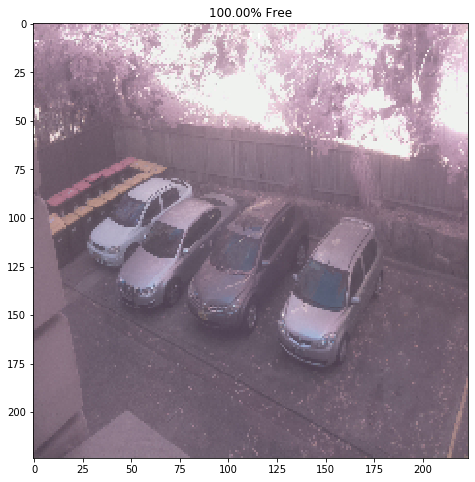

In [24]:
test_img_name = 'Free/img_129173058.jpg'
test_img = img_to_array(load_img(os.path.join(BASE_PATH, test_img_name), target_size=(224,224)))
print('test_img.shape', test_img.shape)

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
print('test_input.shape', test_input.shape)

pred = model.predict(test_input)
print('pred[0]:', pred[0])

plt.figure(figsize=(8,8))

if test_img_name[1] == 'u':
    plt.title('%.2f%% Full' % (pred[0][0] * 100))
else:
    plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

## Draw Activation Map  
왜 판단했는지 알아보기

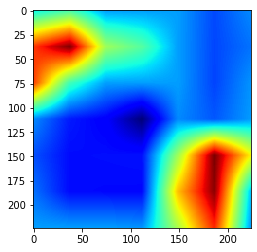

In [25]:
last_conv_output, pred = new_model.predict(test_input) # output 2개

#print('squeeze 전 last_conv_output shape:', last_conv_output.shape)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280)
#print('squeeze 후 last_conv_output shape:', last_conv_output.shape)

feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280)->(224,224,1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

## Result

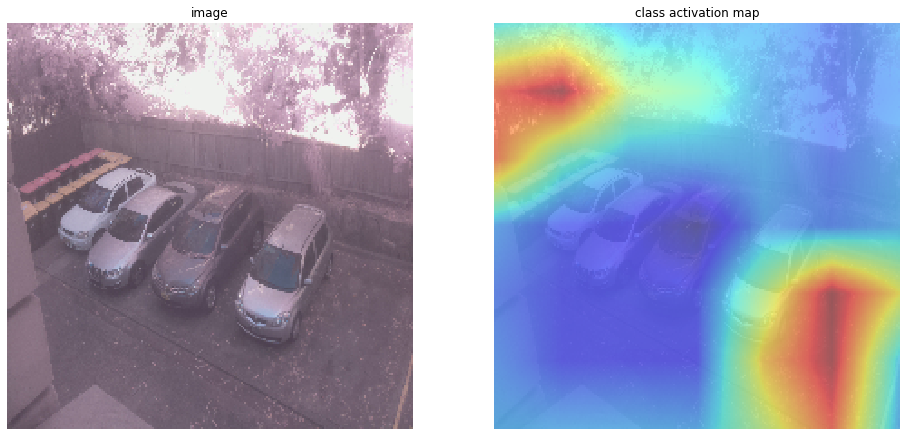

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()